<a href="https://colab.research.google.com/github/Sreejith107/Sentiment-Analysis/blob/main/Sentiment_Analysis_on_Amazon_Alexa_Review.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# **Amazon Alexa Review - Sentiment Analysis**

**Analyzing the Amazon Alexa dataset and building classification models to predict if the sentiment of a given input sentence is Positive or Negative**

**Importing required libraries**

In [107]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import nltk
from nltk.stem.porter import PorterStemmer
nltk.download('stopwords')
from nltk.corpus import stopwords
STOPWORDS = set(stopwords.words('english'))
from nltk.stem import WordNetLemmatizer
nltk.download('wordnet')

from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.model_selection import train_test_split

from sklearn.preprocessing import MinMaxScaler
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.model_selection import cross_val_score
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import StratifiedKFold

from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from sklearn.metrics import accuracy_score

from wordcloud import WordCloud

from xgboost import XGBClassifier

import pickle
import re


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


**Exploratory Data Analysis**

In [108]:
# Load the data
path = '/content/amazon_alexa.tsv'
data = pd.read_csv(path, sep='\t')
data.head()

,rating,date,variation,verified_reviews,feedback
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1
4,5,31-Jul-18,Charcoal Fabric,Music,1


In [109]:
print(f'Number of rows: {data.shape[0]}')
print(f'Number of columns: {data.shape[1]}')
print(f'Dataset Shape: {data.shape}')


Number of rows: 3150
Number of columns: 5
Dataset Shape: (3150, 5)


In [110]:
#Column names

print(f'Feature names: {data.columns.values}')

Feature names: ['rating' 'date' 'variation' 'verified_reviews' 'feedback']


In [111]:
# Checking for null values

data.isnull().sum()

,0
rating,0
date,0
variation,0
verified_reviews,1
feedback,0


In [112]:
# Getting the record where 'verified_reviews' is null

data[data['verified_reviews'].isnull()==True]

,rating,date,variation,verified_reviews,feedback
473,2,29-Jun-18,White,NaN,0


In [113]:
data.dropna(inplace=True)

In [114]:
print(f'After dropping null values:{data.shape}')

After dropping null values:(3149, 5)


In [115]:
#Create a new column 'length' that will contain the length of the string in 'verified_reviews' column

data['length'] = data['verified_reviews'].apply(len)
data.head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [116]:
data.dtypes

,0
rating,int64
date,object
variation,object
verified_reviews,object
feedback,int64
length,int64


### Analyzing the 'rating' column and its count

In [117]:
data['rating'].value_counts()

,count
rating,
5,2286
4,455
1,161
3,152
2,95


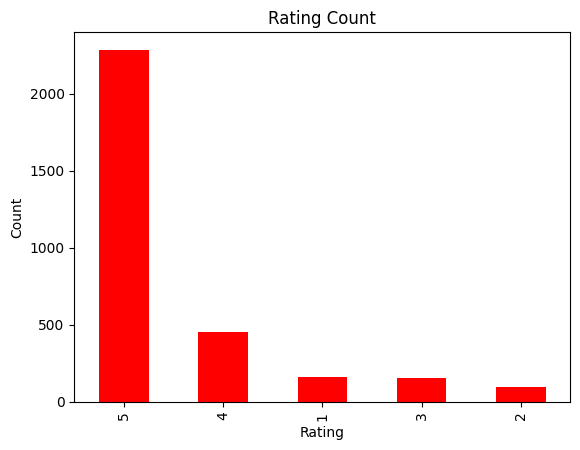

In [118]:
data['rating'].value_counts().plot(kind='bar',color='red')
plt.xlabel('Rating')
plt.ylabel('Count')
plt.title('Rating Count')
plt.show()

In [119]:
#Finding the percentage distribution of each rating.

print(f'Percentage Distribution:\n{round((data["rating"].value_counts() / data.shape[0]) * 100, 2)}')


Percentage Distribution:
rating
5    72.59
4    14.45
1     5.11
3     4.83
2     3.02
Name: count, dtype: float64


### Analyzing the 'feedback' column

In [120]:
data['feedback'].value_counts()

,count
feedback,
1,2893
0,256


In [121]:
data[data['feedback']==1].head()

,rating,date,variation,verified_reviews,feedback,length
0,5,31-Jul-18,Charcoal Fabric,Love my Echo!,1,13
1,5,31-Jul-18,Charcoal Fabric,Loved it!,1,9
2,4,31-Jul-18,Walnut Finish,"Sometimes while playing a game, you can answer...",1,195
3,5,31-Jul-18,Charcoal Fabric,I have had a lot of fun with this thing. My 4 ...,1,172
4,5,31-Jul-18,Charcoal Fabric,Music,1,5


In [122]:
data[data['feedback']==0].head()

,rating,date,variation,verified_reviews,feedback,length
46,2,30-Jul-18,Charcoal Fabric,"It's like Siri, in fact, Siri answers more acc...",0,163
111,2,30-Jul-18,Charcoal Fabric,Sound is terrible if u want good music too get...,0,53
141,1,30-Jul-18,Charcoal Fabric,Not much features.,0,18
162,1,30-Jul-18,Sandstone Fabric,"Stopped working after 2 weeks ,didn't follow c...",0,87
176,2,30-Jul-18,Heather Gray Fabric,Sad joke. Worthless.,0,20


From above we can see that feedback = 1 then it is 'Positive' , feedback = 0 it is 'Negative'.

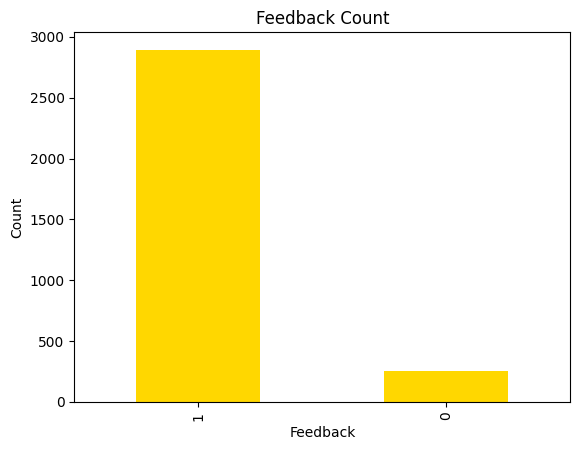

In [123]:
data['feedback'].value_counts().plot(kind='bar',color='gold')
plt.xlabel('Feedback')
plt.ylabel('Count')
plt.title('Feedback Count')
plt.show()

In [124]:
round((data['feedback'].value_counts() / data.shape[0]) * 100,2)

,count
feedback,
1,91.87
0,8.13


###'rating' values for different values of 'feedback'

In [125]:
data[data['feedback']==0]['rating'].value_counts()

,count
rating,
1,161
2,95


In [126]:
data[data['feedback']==1]['rating'].value_counts()

,count
rating,
5,2286
4,455
3,152


### Analysing 'variation' column

In [127]:
data['variation'].value_counts()

,count
variation,
Black Dot,516
Charcoal Fabric,430
Configuration: Fire TV Stick,350
Black Plus,270
Black Show,265
Black,261
Black Spot,241
White Dot,184
Heather Gray Fabric,157


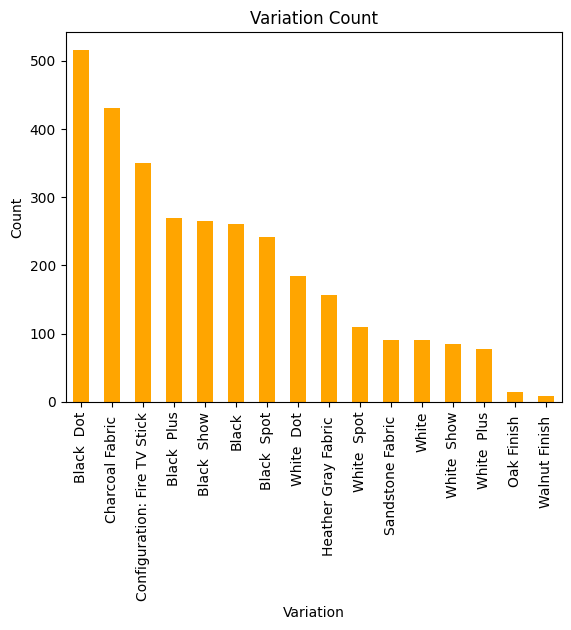

In [128]:
data['variation'].value_counts().plot(kind='bar',color='orange')
plt.xlabel('Variation')
plt.ylabel('Count')
plt.title('Variation Count')
plt.show()

In [129]:
round((data['variation'].value_counts() / data.shape[0] )*100,2)

,count
variation,
Black Dot,16.39
Charcoal Fabric,13.66
Configuration: Fire TV Stick,11.11
Black Plus,8.57
Black Show,8.42
Black,8.29
Black Spot,7.65
White Dot,5.84
Heather Gray Fabric,4.99


### Average rating according to variaton

In [130]:
data.groupby(by='variation')['rating'].mean()

,rating
variation,
Black,4.233716
Black Dot,4.453488
Black Plus,4.370370
Black Show,4.490566
Black Spot,4.311203
Charcoal Fabric,4.730233
Configuration: Fire TV Stick,4.591429
Heather Gray Fabric,4.694268
Oak Finish,4.857143


Text(0.5, 1.0, 'Variation vs Average Rating')

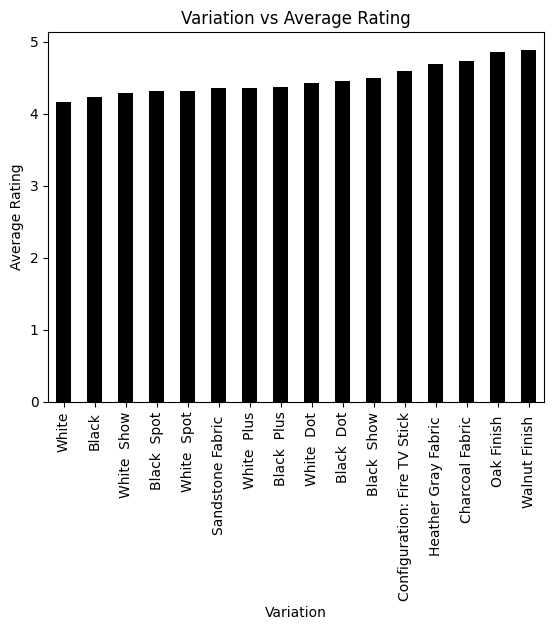

In [131]:
data.groupby(by='variation')['rating'].mean().sort_values().plot(kind='bar',color='black')
plt.xlabel('Variation')
plt.ylabel('Average Rating')
plt.title('Variation vs Average Rating')

### Analyzing 'verified_reviews'

In [132]:
data['length'].describe()

,length
count,3149.000000
mean,132.090187
std,182.114569
min,1.000000
25%,30.000000
50%,74.000000
75%,165.000000
max,2851.000000


[Text(0.5, 0, 'Length'), Text(0, 0.5, 'Count')]

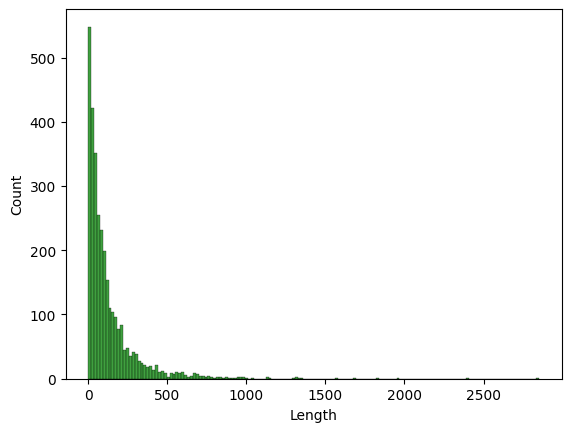

In [133]:
sns.histplot(data['length'],color='green').set(xlabel='Length',ylabel='Count')

Text(0.5, 1.0, 'Length vs Average Rating')

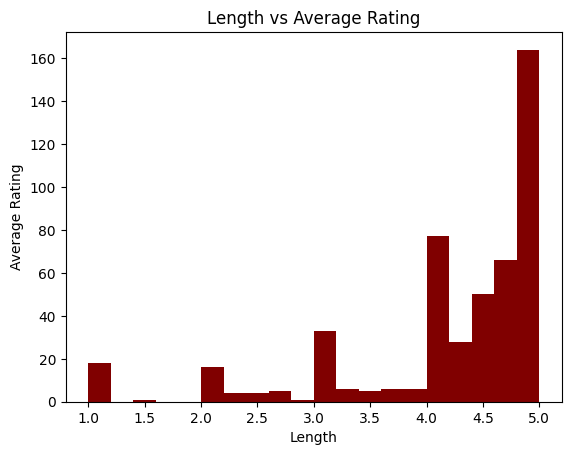

In [134]:
data.groupby(by='length')['rating'].mean().plot(kind='hist',color='maroon',bins=20)
plt.xlabel('Length')
plt.ylabel('Average Rating')
plt.title('Length vs Average Rating')

In [135]:
cv = CountVectorizer(stop_words='english')
words = cv.fit_transform(data['verified_reviews'])

In [136]:
#combine all reviews
reviews = ''.join([review for review in data['verified_reviews']])

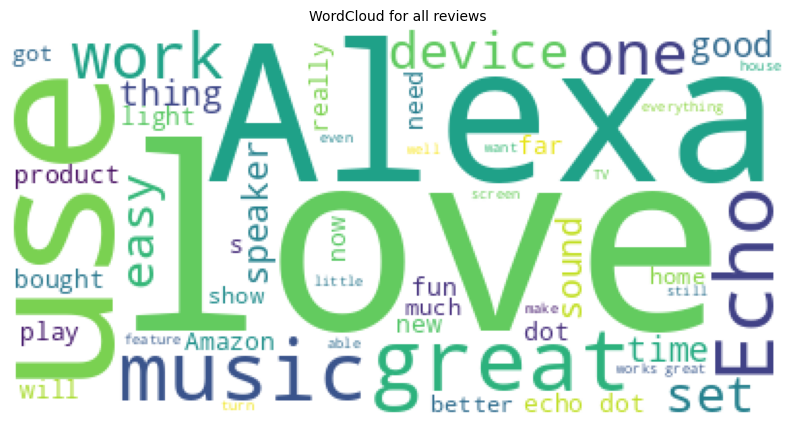

In [137]:
#Initialize wordcloud object
wc = WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(reviews))
plt.title('WordCloud for all reviews',fontsize=10)
plt.axis('off')
plt.show()

### Lets find the unique words in each feedback category

In [138]:
# Combine all reviews for each feedback category and splitting them into induvidual words

neg_review = ''.join([review for review in data[data['feedback']==0]['verified_reviews']])
neg_review = neg_review.lower().split()

pos_review = ''.join([review for review in data[data['feedback']==1]['verified_reviews']])
pos_review = pos_review.lower().split()

In [139]:
# Finding words from reviews which are present in that feedback

unique_negative = [word for word in neg_review if word not in pos_review]
unique_negative = ''.join(unique_negative)

unique_positive = [word for word in pos_review if word not in neg_review]
unique_positive = ''.join(unique_positive)

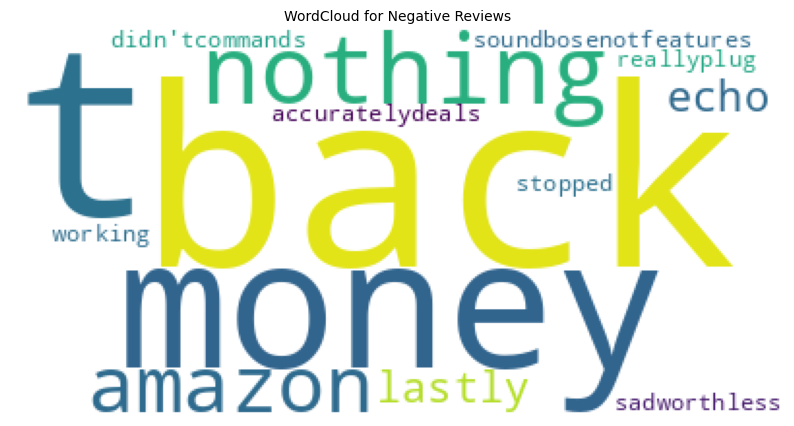

In [140]:
wc = WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_negative))
plt.title('WordCloud for Negative Reviews',fontsize=10)
plt.axis('off')
plt.show()

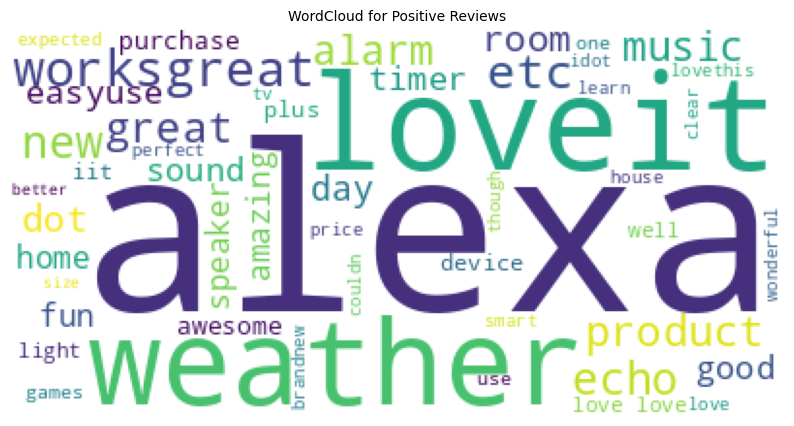

In [141]:
wc = WordCloud(background_color='white',max_words=50)

plt.figure(figsize=(10,10))
plt.imshow(wc.generate(unique_positive))
plt.title('WordCloud for Positive Reviews',fontsize=10)
plt.axis('off')
plt.show()

# **Preprocessing and Modelling**

#####**To build the corpus from the 'verified reviews' we perform the following**

1.   Replace any non alphabet characters with a space
2.   Convert to lower case and split into words
3.   Iterate over the induvidual words and if it is not stopword then add the stemmed form of the word to the corpus



In [142]:
corpus = []
stemmer = PorterStemmer()

for i in range(0,data.shape[0]):
  review = re.sub('[^a-zA-Z]',' ',data.iloc[i]['verified_reviews'])
  review = review.lower().split()
  review = [stemmer.stem(word) for word in review if word not in STOPWORDS]

  review = ''.join(review)
  corpus.append(review)

**Using Count Vectorizer to create bag of words**

In [143]:
cv = CountVectorizer(max_features=2500)

#Storing independent and dependent variables in x and y
x = cv.fit_transform(corpus).toarray()
y = data['feedback'].values

In [144]:
#Saving the count vectorizer
pickle.dump(cv,open('countVectorizer.pkl','wb'))

In [145]:
# Checking the shape of X and y

print(f'X shape: {x.shape}')
print(f'y shape: {y.shape}')

X shape: (3149, 2161)
y shape: (3149,)


**Splitting data into train and test. Set with 30% data with testing**

In [146]:
X_train,X_test,y_train,y_test = train_test_split(x,y,test_size=0.3,random_state=15)

print(f'X train: {X_train.shape}')
print(f'X test: {X_test.shape}')
print(f'y train: {y_train.shape}')
print(f'y test: {y_test.shape}')

X train: (2204, 2161)
X test: (945, 2161)
y train: (2204,)
y test: (945,)


**We'll scale X_train and X_test so that all values are between 0 and 1**

In [147]:
scaler = MinMaxScaler()

X_train_scl = scaler.fit_transform(X_train)
X_test_scl = scaler.transform(X_test)

In [148]:
#Saving the scaler model
pickle.dump(scaler,open('scaler.pkl','wb'))

# **Random Forest**

In [150]:
#Fitting scaled X_train and y_trsin on Random Forest Classifier

model_rf = RandomForestClassifier()
model_rf.fit(X_train_scl,y_train)

RandomForestClassifier()

In [151]:
#Accuracy of the model on training and testing data

print(f'Training Accuracy: {model_rf.score(X_train_scl,y_train)}')
print(f'Testing Accuracy: {model_rf.score(X_test_scl,y_test)}')

Training Accuracy: 0.9945553539019963
Testing Accuracy: 0.9375661375661376


In [152]:
#Predicting on the test set
y_pred = model_rf.predict(X_test_scl)

In [154]:
#Confusion Matrix
cm = confusion_matrix(y_test,y_pred)

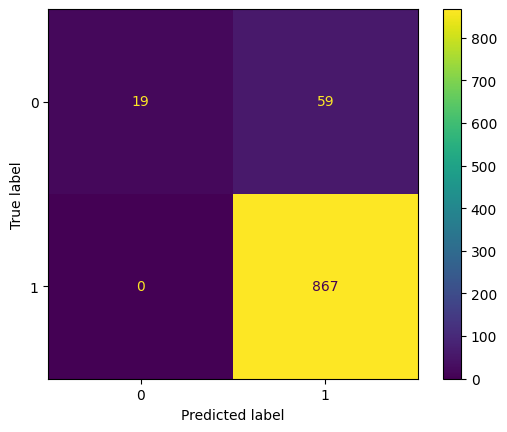

In [155]:
cm_display = ConfusionMatrixDisplay(cm,display_labels=model_rf.classes_)
cm_display.plot()
plt.show()

In [157]:
accuracies = cross_val_score(estimator=model_rf,X=X_train_scl,y=y_train,cv=10)
print(f'Accuracy: {round(accuracies.mean()*100,2)} %')
print(f'Standard Variance: {round(accuracies.std()*100,2)} %')

Accuracy: 92.83 %
Standard Variance: 0.69 %
